# Solve the normal mode eigenvalue problem that arises in GFD problems

$$
\frac{d^2 \phi}{dz^2} + \frac{N^2}{c^2}\phi = 0
$$

Use the `waves_on_a_string.py` example as a starting point...

In [1]:
import dedalus.public as de
import numpy as np
import matplotlib.pyplot as plt
import logging
import time
logger = logging.getLogger(__name__)



In [10]:
%matplotlib inline

In [230]:
# Domain
Nz = 128
H = 400
#N2 = 1e-4

z_basis = de.Chebyshev('z', Nz, interval=(-H, 0))
domain = de.Domain([z_basis], np.complex128)

z = z_basis.grid()
z

array([ -3.99984940e+02,  -3.99864477e+02,  -3.99623623e+02,
        -3.99262522e+02,  -3.98781394e+02,  -3.98180527e+02,
        -3.97460284e+02,  -3.96621097e+02,  -3.95663474e+02,
        -3.94587990e+02,  -3.93395294e+02,  -3.92086104e+02,
        -3.90661208e+02,  -3.89121465e+02,  -3.87467802e+02,
        -3.85701216e+02,  -3.83822770e+02,  -3.81833597e+02,
        -3.79734893e+02,  -3.77527924e+02,  -3.75214019e+02,
        -3.72794571e+02,  -3.70271039e+02,  -3.67644941e+02,
        -3.64917861e+02,  -3.62091440e+02,  -3.59167381e+02,
        -3.56147446e+02,  -3.53033453e+02,  -3.49827279e+02,
        -3.46530854e+02,  -3.43146165e+02,  -3.39675250e+02,
        -3.36120200e+02,  -3.32483156e+02,  -3.28766309e+02,
        -3.24971898e+02,  -3.21102208e+02,  -3.17159571e+02,
        -3.13146362e+02,  -3.09064998e+02,  -3.04917937e+02,
        -3.00707677e+02,  -2.96436754e+02,  -2.92107742e+02,
        -2.87723248e+02,  -2.83285912e+02,  -2.78798408e+02,
        -2.74263439e+02,

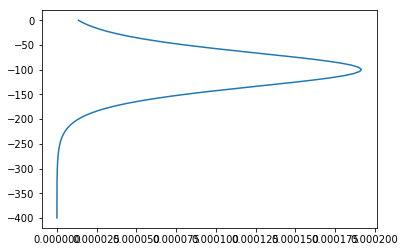

In [233]:
def sech(z):
    return 1/np.cosh(z)

def sech_N2(beta,z):
    N1 = 9.81/1024*(beta[1]/beta[3])
    cff = sech((z+beta[2])/beta[3]) #+ np.exp(z/beta[0])
    return N1*cff*cff
    
beta = [2000,1.0,100,50]

plt.figure()
plt.plot(sech_N2(beta,z),z)

In [234]:
# Problem
problem = de.EVP(domain, variables=['phi', 'phi_z'],eigenvalue='c')

# Constant buoyancy frequency
#problem.parameters['N2'] = N2

# Add vertically varying N^2
ncc = domain.new_field(name = 'N2')
ncc['g'] = sech_N2(beta,z)
problem.parameters['N2'] = ncc

problem.add_equation("phi * N2 *c + dz(phi_z) = 0")
problem.add_equation("phi_z - dz(phi) = 0")
#problem.add_bc("left(phi) = 0")
problem.add_bc("right(phi) = 0")
problem.add_bc("left(phi) = 0")


2020-01-16 13:40:12,971 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [235]:
# Solver
t1 = time.time()

solver = problem.build_solver()
solver.solve(solver.pencils[0])
t2 = time.time()
logger.info('Elapsed solve time: %f' %(t2-t1))

2020-01-16 13:40:15,199 __main__ 0/1 INFO :: Elapsed solve time: 1.364400


/home/dedalus/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: divide by zero encountered in true_divide
  w = alpha / beta
/home/dedalus/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: invalid value encountered in true_divide
  w = alpha / beta


In [236]:
# Filter infinite/nan eigenmodes
finite = np.isfinite(solver.eigenvalues)
solver.eigenvalues = solver.eigenvalues[finite]
solver.eigenvectors = solver.eigenvectors[:, finite]

# Sort eigenmodes by eigenvalue
order = np.argsort(solver.eigenvalues)
solver.eigenvalues = solver.eigenvalues[order]
solver.eigenvectors = solver.eigenvectors[:, order]

# Plot error vs exact eigenvalues
mode_number = 1 + np.arange(len(solver.eigenvalues))


In [237]:
1/np.sqrt(np.abs(solver.eigenvalues))

array([  1.02304758e+00,   3.62236721e-01,   2.26857209e-01,
         1.65917942e-01,   1.30989198e-01,   1.08283512e-01,
         9.23195049e-02,   8.04744774e-02,   7.13326223e-02,
         6.40614210e-02,   5.81389284e-02,   5.32211286e-02,
         4.90719829e-02,   4.55241037e-02,   4.24554644e-02,
         3.97749966e-02,   3.74133508e-02,   3.53167824e-02,
         3.34429931e-02,   3.17582362e-02,   3.02352585e-02,
         2.88518103e-02,   2.75895404e-02,   2.64331742e-02,
         2.53699282e-02,   2.43889592e-02,   2.34808409e-02,
         2.26368992e-02,   2.18500511e-02,   2.11095392e-02,
         2.04080712e-02,   1.97251671e-02,   1.90686397e-02,
         1.84044260e-02,   1.77618801e-02,   1.70966980e-02,
         1.64701658e-02,   1.58193994e-02,   1.52084063e-02,
         1.45740371e-02,   1.39938562e-02,   1.33934266e-02,
         1.28376273e-02,   1.22649273e-02,   1.17481491e-02,
         1.12157846e-02,   1.07266754e-02,   1.02227440e-02,
         9.77632120e-03,

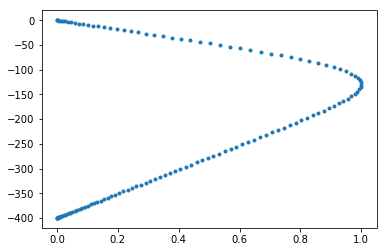

In [239]:
def norm(V):
    if np.max(V)>np.abs(np.min(phi)):
        return V/np.max(V)
    else:
        return V/np.min(V)

# This is the method for extracting the eigenvalue in physical space    
mode=0
solver.set_state(mode)
phi = solver.state['phi']['g'].real

plt.figure()

plt.plot(norm(phi),z,'.')
